<a href="https://colab.research.google.com/github/pannhapat/udacity_1001/blob/master/06_digit_predictor_CNN_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Hyper parameter settings
epochs = 10 #@param {type:"number"}
batch_size = 128 #@param {type:"integer"}
learning_rate = 0.001 #@param {type:"number"}
dropout_rate = 0.05 #@param {type:"number"}


In [0]:
#the majority of the code is taken from official keras github
#the rest will have reference at the start of the cell
#https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from keras.optimizers import RMSprop

num_classes = 10





In [0]:
# the data, split between train and test sets
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()



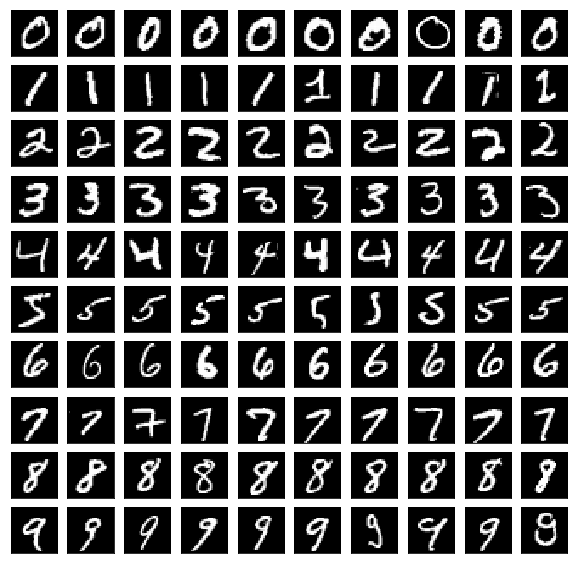

In [0]:
#code to plot samples is modified from the soure below
#http://parneetk.github.io/blog/neural-networks-in-keras/

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

for i in range(num_classes):
  for j in range(10):
    ax = fig.add_subplot(10, 10, 1 + i*10  + j, xticks=[], yticks=[])
    features_idx = x_train_org[y_train_org[:]==i,:]
    plt.imshow(features_idx[j], cmap="gray")
plt.show()

In [0]:
#soure of Thai MNIST dataset on github and how to retrieve the data 
#https://github.com/nextwaverr/Thai-MNIST
#https://github.com/nextwaverr/Thai-MNIST/blob/master/Thai_MNIST_Example.py

#the link to the dataset file
#need to unzip and upload the files to google drive first
#https://drive.google.com/open?id=1cZmfAfYXegdGGNISboq7pvPR-KnXmduw

from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels

import os

datasetpath = '' # Change to path to mapped folder

with open(os.path.join(datasetpath, 'train-images-idx3-ubyte.gz'), 'rb') as f:
    x_train_th = extract_images(f)
with open(os.path.join(datasetpath, 'train-labels-idx1-ubyte.gz'), 'rb') as f:
    y_train_th = extract_labels(f)
with open(os.path.join(datasetpath, 'test-images-idx3-ubyte.gz'), 'rb') as f:
    x_test_th = extract_images(f)
with open(os.path.join(datasetpath, 'test-labels-idx1-ubyte.gz'), 'rb') as f:
    y_test_th = extract_labels(f)


W0820 16:56:08.062126 140637861480320 deprecation.py:323] From <ipython-input-22-4e82fa99ecef>:9: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting train-images-idx3-ubyte.gz


W0820 16:56:10.095679 140637861480320 deprecation.py:323] From <ipython-input-22-4e82fa99ecef>:11: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting train-labels-idx1-ubyte.gz
Extracting test-images-idx3-ubyte.gz
Extracting test-labels-idx1-ubyte.gz


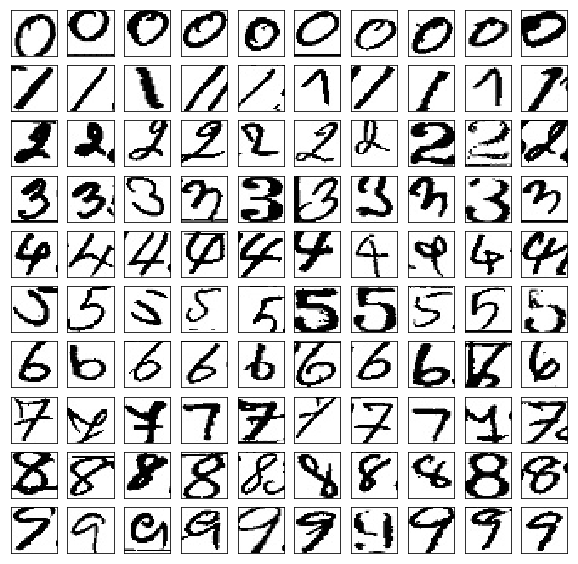

In [0]:
#the shape is Thai MNIST is a little different
#need to reshape so that pyplot can show images
x_train_th = x_train_th.reshape(x_train_th.shape[0]\
                                , x_train_th.shape[1], x_train_th.shape[2])

fig = plt.figure(figsize=(10,10))

for i in range(num_classes):
  for j in range(10):
    ax = fig.add_subplot(10, 10, 1 + i*10  + j, xticks=[], yticks=[])
    #print((y_train[:]==i)[0:10])
    features_idx = x_train_th[y_train_th[:]==i,:]
    #ax.set_title("Num: " + str(i))
    plt.imshow(features_idx[j], cmap="gray")
plt.show()

In [0]:
#pre-process the data
#we reshape the dataset to be flat as the input for the model is also 1D
#note 

import numpy as np

x_train_org = x_train_org.reshape(x_train_org.shape[0], 28, 28, 1)
x_test_org = x_test_org.reshape(x_test_org.shape[0], 28, 28, 1)
x_train_org = x_train_org.astype('float32')
x_test_org = x_test_org.astype('float32')
x_train_org /= 255.
x_test_org /= 255.

# convert class vectors to binary class matrices
y_train_org_onehot = keras.utils.to_categorical(y_train_org, num_classes)
y_test_org_onehot = keras.utils.to_categorical(y_test_org, num_classes)

print(x_train_org.shape[0], 'train samples - original')
print(x_test_org.shape[0], 'test samples - original')


x_train_th = x_train_th.reshape(x_train_th.shape[0], 28, 28, 1)
x_test_th = x_test_th.reshape(x_test_th.shape[0], 28, 28 ,1)
x_train_th = x_train_th.astype('float32')
x_test_th = x_test_th.astype('float32')
x_train_th /= 255.
x_test_th /= 255.

# convert class vectors to binary class matrices
y_train_th_onehot = keras.utils.to_categorical(y_train_th, num_classes)
y_test_th_onehot = keras.utils.to_categorical(y_test_th, num_classes)

print(x_train_th.shape[0], 'train samples - Thai')
print(x_test_th.shape[0], 'test samples - Thai')



#merge both dataset into one
#note the color of one dataset is different from the other
#this converts on the preference of Thai MNIST (that the background is white) 
#so we subtract the value out of one to inverse the color 
x_train_combo = np.concatenate((1. - x_train_org, x_train_th), axis = 0)
y_train_combo = np.concatenate((y_train_org_onehot, y_train_th_onehot), axis = 0)

x_test_combo = np.concatenate((1. - x_test_org, x_test_th), axis = 0)
y_test_combo = np.concatenate((y_test_org_onehot, y_test_th_onehot), axis = 0)

print(x_train_combo.shape[0], 'train samples - all')
print(x_test_combo.shape[0], 'test samples - all')

60000 train samples - original
10000 test samples - original
284977 train samples - Thai
31659 test samples - Thai
344977 train samples - all
41659 test samples - all


In [0]:
model = Sequential()
model.add(Conv2D(6, 5, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, 5, padding='valid', activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(84, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_5 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_8 (Dense)              (None, 84)                10164     
__________

In [0]:
simple_model = Sequential()
simple_model.add(Dense(3, activation='relu', input_shape=(5,),\
                       name = 'hidden_layer_1'))
simple_model.add(Dense(3, activation='relu', name = 'hidden_layer_2'))
simple_model.add(Dense(1, activation='sigmoid', name = 'output_layer'))

simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 3)                 18        
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 3)                 12        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 4         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=learning_rate),
              metrics=['accuracy'])

history = model.fit(x_train_combo, y_train_combo,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_combo, y_test_combo))

W0820 16:58:03.682032 140637861480320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 16:58:03.827844 140637861480320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 344977 samples, validate on 41659 samples
Epoch 1/10
344977/344977 [==============================] - 28s 81us/step - loss: 0.2140 - acc: 0.9323 - val_loss: 0.0644 - val_acc: 0.9801
Epoch 2/10
344977/344977 [==============================] - 27s 80us/step - loss: 0.0518 - acc: 0.9844 - val_loss: 0.0682 - val_acc: 0.9783
Epoch 3/10
344977/344977 [==============================] - 28s 80us/step - loss: 0.0380 - acc: 0.9887 - val_loss: 0.0516 - val_acc: 0.9846
Epoch 4/10
344977/344977 [==============================] - 27s 80us/step - loss: 0.0315 - acc: 0.9905 - val_loss: 0.0349 - val_acc: 0.9892
Epoch 5/10
344977/344977 [==============================] - 27s 79us/step - loss: 0.0276 - acc: 0.9918 - val_loss: 0.0400 - val_acc: 0.9889
Epoch 6/10
344977/344977 [==============================] - 27s 78us/step - loss: 0.0256 - acc: 0.9924 - val_loss: 0.0357 - val_acc: 0.9897
Epoch 7/10
344977/344977 [==============================] - 27s 78us/step - loss: 0.0234 - acc: 0.9932 - val_

In [0]:
score = model.evaluate(x_test_combo, y_test_combo, verbose=0)
print('Test loss - all:', score[0])
print('Test accuracy - all:', score[1])

#evaluate the model with original dataset - with inverse color
score = model.evaluate((1. - x_test_org), y_test_org_onehot, verbose=0)
print('\nTest loss - original:', score[0])
print('Test accuracy - original:', score[1])

#evaluate the model with only Thai MNIST dataset
score = model.evaluate(x_test_th, y_test_th_onehot, verbose=0)
print('\nTest loss - Thai:', score[0])
print('Test accuracy - Thai:', score[1])

Test loss - all: 0.035935299793315285
Test accuracy - all: 0.9902061979404211

Test loss - original: 0.03864906030194688
Test accuracy - original: 0.9871

Test loss - Thai: 0.03507811517675216
Test accuracy - Thai: 0.9911873400928646


Text(0.5, 1.0, 'Training and validation loss')

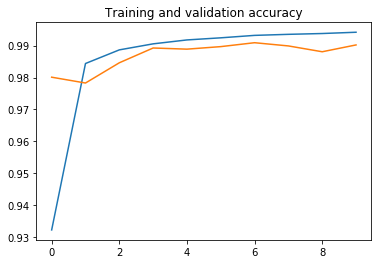

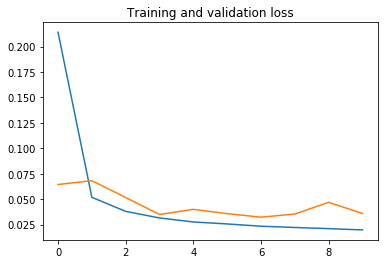

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')



x shape before expanding the dimension:  (28, 28, 3)
x shape after expanding the dimension:  (1, 28, 28, 3)
x shape after converting to grayscale:  (1, 28, 28)
x shape after reshaping for the model input:  (1, 28, 28, 1)
Shape of prediction:  (1, 10)
Prediction of the input:  [[9.71444460e-05 6.43029332e-01 2.16291446e-05 1.58330735e-08
  3.56716812e-01 2.13985663e-06 2.39436577e-05 1.12552527e-07
  1.18983635e-05 9.70372203e-05]]
Max probability:  0.64302933
Index of max prob:  (array([0]), array([1]))


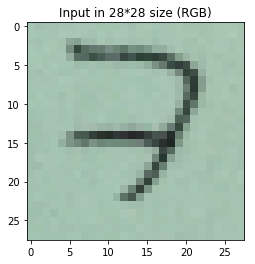

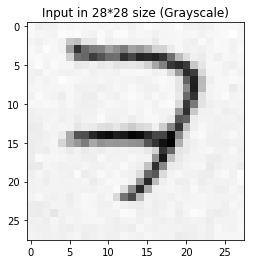

In [0]:
from keras.preprocessing import image
import numpy as np

img_path = 'Sample7.jpg'
img = image.load_img(img_path, target_size=(28,28))
x = image.img_to_array(img)
x /= 255.
plt.title('Input in 28*28 size (RGB)')
plt.imshow(x)
plt.figure()

print('x shape before expanding the dimension: ', x.shape)
x = np.expand_dims(x, axis = 0)

print('x shape after expanding the dimension: ', x.shape)

x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])
print('x shape after converting to grayscale: ', x.shape)


#x = x_test_combo[25000]
#x = x.reshape(1,28,28)
plt.title('Input in 28*28 size (Grayscale)')
plt.imshow(x[0], cmap="gray")

x = x.reshape(x.shape[0],  28, 28, 1)
print('x shape after reshaping for the model input: ', x.shape)

y = model.predict(x)
#x_test_org

print('Shape of prediction: ', y.shape)

print('Prediction of the input: ',y)

print('Max probability: ', np.max(y))

print('Index of max prob: ', np.where(y == np.max(y)))




In [0]:
y = model.predict(x)

print(y)


[[8.9354885e-01 1.4545490e-03 5.0254451e-04 6.7053840e-04 5.0300773e-04
  5.0780401e-02 2.0163029e-03 1.7180278e-03 4.1802279e-03 4.4625577e-02]]
